In [283]:
from astropy.io import ascii
import matplotlib.pyplot as plt
import numpy as np

In [284]:
data = ascii.read("FishVBM_Therr_m20_2_52.out")

In [285]:
event_126 = data[data["EventID"] == 126]
print(event_126)


EventID SubRun Field ... ObsGroup_0_Fbase2_err ObsGroup_0_fs2_err LCOutput
------- ------ ----- ... --------------------- ------------------ --------
    126      2    52 ...     0.000948879943335  0.001267401531059        1


In [286]:
lc_data = ascii.read("FishVBM_Therr_m20_2_52_126.det.lc")

In [287]:
def parse_prm_file(filepath):
    params = {}
    with open(filepath, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith("#") or "=" not in line:
                continue
            key, value = line.split("=", 1)
            params[key.strip()] = value.strip()
    return params

params = parse_prm_file("FVBM_m20.prm")

print(params)

{'RUN_NAME': 'FishVBM_Therr_m20', 'OUTPUT_DIR': '/work/fzohrabi/gulls_output/test/', 'FINAL_DIR': '/work/fzohrabi/gulls_output/test/', 'EXECUTABLE': 'gullsFish.x', 'OBSERVATORY_DIR': 'observatories/', 'OBSERVATORY_LIST': 'Roman_test_WZK.list', 'WEATHER_PROFILE_DIR': 'weather/', 'STARFIELD_DIR': 'starfields/', 'STARFIELD_LIST': 'gulls_surot2d_H2023.starfields', 'SOURCE_DIR': 'sources/', 'SOURCE_LIST': 'gulls_surot2d_H2023.sources', 'SOURCE_COLOURS': '0', 'LENS_DIR': 'lenses/', 'LENS_LIST': 'gulls_surot2d_H2023.lenses', 'LENS_COLOURS': '0', 'LENS_LIGHT': '1', 'PLANET_DIR': 'planet/m+20/', 'PLANET_ROOT': 'm+20.planets.', 'RATES_FILE': 'rates/src_gulls_surot2d_H2023.rates.v2', 'PRINCIPLE_OBSERVATORY': '0', 'OUTPUT_LC': '1', 'OUTPUT_IMAGES': '0', 'PRETTY_PICS': '0', 'PRETTY_PICS_DIMENSIONS': '128', 'OUTPUT_ONERR': '0', 'OUTPUT_ONDET': '1', 'OUTPUT_ONALL': '0', 'OUTPUT_FISH': '1', 'IDEAL_PHOTOMETRY': '-1', 'PARALLAX': '1', 'OBS_GROUPS': '(0,1,2)', 'NOBS': '3', 'NOBS_GROUPS': '1', 'OBS_GROUP_

In [288]:
sim_zero_time = float(params["SIMULATION_ZERO_TIME"])

## Sanity Check

In [289]:
#from .out file
row = event_126[0]  
t0_ref = row["t0lens1"]
tE = row["tE_ref"]
rho = row["rho"]
u0_list = [row["u0lens1"]]
alpha = row["alpha"]
q = row["Planet_q"]
s = row["Planet_s"]

t0 = abs(t0_ref - sim_zero_time)

In [290]:
#manually from data available from the .lc file
mask = lc_data['col6'] == 0 #0 is the data we need

# Extract positions
source_x = lc_data['col12'][mask]
source_y = lc_data['col13'][mask]
lens1_x = lc_data['col14'][mask]
lens1_y = lc_data['col15'][mask]
lens2_x = lc_data['col16'][mask]
lens2_y = lc_data['col17'][mask] 
bjd = lc_data["col11"][mask]



#Extract flux
flux = lc_data["col4"][mask]
flux_error = lc_data["col5"][mask]
#s
s_lc = lens2_x[0] - lens1_x[0]

#distance to lens
dist = np.sqrt((source_x - lens1_x)**2 + (source_y - lens1_y)**2)

#t0: time of closest approach
idx_min = np.argmin(dist)
t0_lc = bjd[idx_min]

#tE
ds = np.sqrt((source_x[-1] - source_x[0])**2 + (source_y[-1] - source_y[0])**2)
dt = bjd[-1] - bjd[0]
v = ds / dt
tE_lc = 1.0 / v  # in days

#tau
tau_lc = (bjd - t0_lc) / tE_lc

#alpha
dx = source_x[-1] - source_x[0]
dy = source_y[-1] - source_y[0]
alpha_rad = np.arctan2(dy, dx)
alpha_deg = np.degrees(alpha_rad) % 360  

#u0 parameter
x0 = source_x[len(source_x) // 2]
y0 = source_y[len(source_y) // 2]

numerator = abs(dx * y0 - dy * x0)
denominator = np.sqrt(dx**2 + dy**2)
u0_lc = numerator / denominator

print(f'Estimated s = {s_lc:.6},', f'GULLS output s={s}')
print(f'Estimated t0 = {t0_lc:.10},', f'GULLS output t0={t0}')
print(f'Estimated tE = {tE_lc:.6},', f'GULLS output tE={tE}')
print(f"Estimated alpha = {alpha_deg:.4f} degrees,", f'GULLS output alpha={alpha}')
print(f"Estimated u0 = {u0_lc:.6f},", f'GULLS output u0={u0_list}')

Estimated s = 1.34777, GULLS output s=1.347771197642
Estimated t0 = 2458261.929, GULLS output t0=2458206.0703329355
Estimated tE = 4.40305, GULLS output tE=4.403168559902
Estimated alpha = 274.3129 degrees, GULLS output alpha=274.3131637573
Estimated u0 = 0.086032, GULLS output u0=[np.float64(-0.08453353201416)]


## Comparing Model

In [291]:
from ML import TwoLens1S
model = TwoLens1S(t0=t0_lc, tE=tE, rho=rho, u0_list=[-0.08453353201416], q=q, s=s, alpha=alpha, t_lc=bjd)
model2 = TwoLens1S(t0=t0_lc, tE=tE_lc, rho=rho, u0_list=[-u0_lc], q=q, s=s_lc, alpha=alpha_deg, t_lc=bjd)


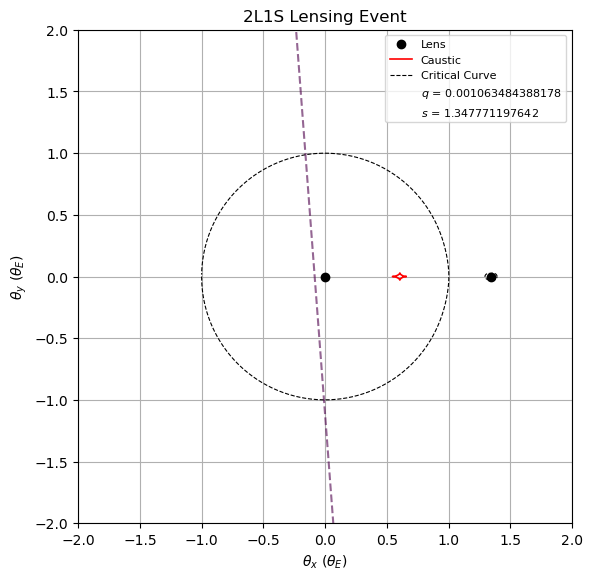

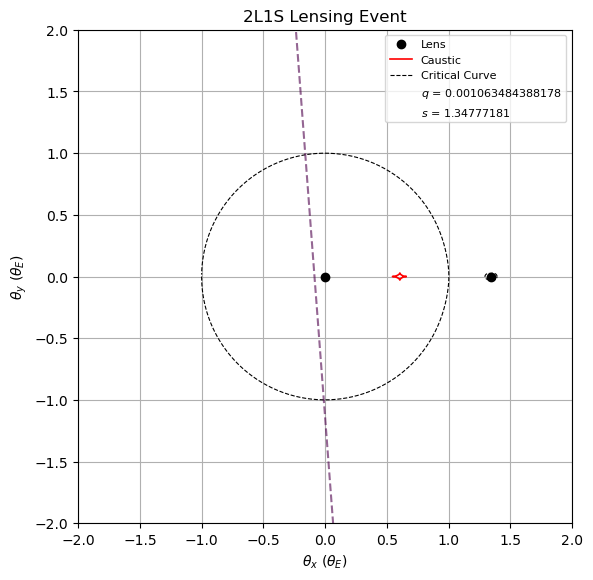

In [306]:
model.plot_caustic_critical_curves()
model2.plot_caustic_critical_curves()

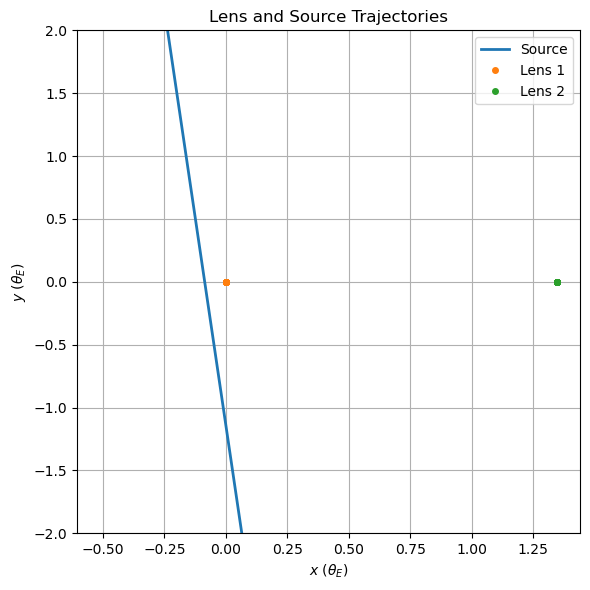

In [293]:
plt.figure(figsize=(6, 6))

# Plot source trajectory
plt.plot(source_x, source_y, label="Source", lw=2)

# Plot lens positions (assumed fixed)
plt.plot(lens1_x, lens1_y, 'o', label="Lens 1", markersize=4)
plt.plot(lens2_x, lens2_y, 'o', label="Lens 2", markersize=4)

plt.ylim(-2,2)
plt.xlabel(r"$x$ ($\theta_E$)")
plt.ylabel(r"$y$ ($\theta_E$)")
plt.title("Lens and Source Trajectories")
#plt.gca().set_aspect('equal')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [294]:
model_tau = model.tau_lc
model_mag = model.systems[0]["mag"]

model2_tau = model2.tau_lc
model2_mag = model2.systems[0]["mag"]

In [295]:
print(flux_error)

   col5   
----------
 0.0080608
0.00806081
0.00806081
0.00806082
0.00806082
0.00806083
0.00806083
0.00806084
0.00806084
0.00806084
       ...
0.00805845
0.00805845
0.00805845
0.00805845
0.00805845
0.00805845
0.00805845
0.00805845
0.00805845
0.00805845
Length = 6756 rows


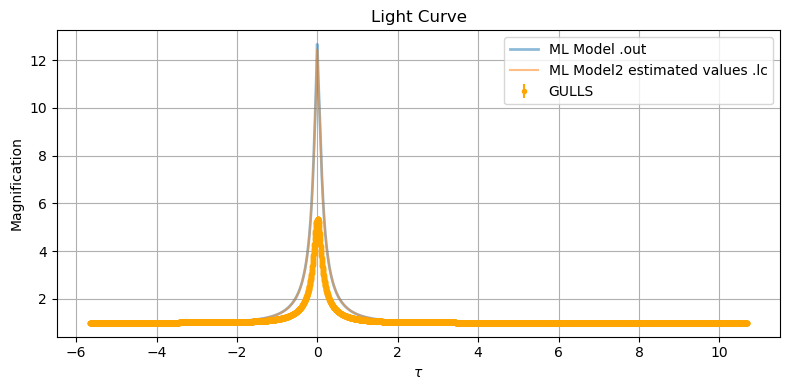

In [296]:
plt.figure(figsize=(8, 4))
plt.errorbar(tau_lc, flux, label='GULLS', color='orange', yerr=flux_error, fmt='.')

plt.plot(model_tau, model_mag, label= "ML Model .out", lw=2, alpha = .5)
plt.plot(model2_tau, model2_mag, label ="ML Model2 estimated values .lc", alpha =.5)
plt.xlabel(r"$\tau$")
plt.ylabel("Magnification")
plt.title("Light Curve")


plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


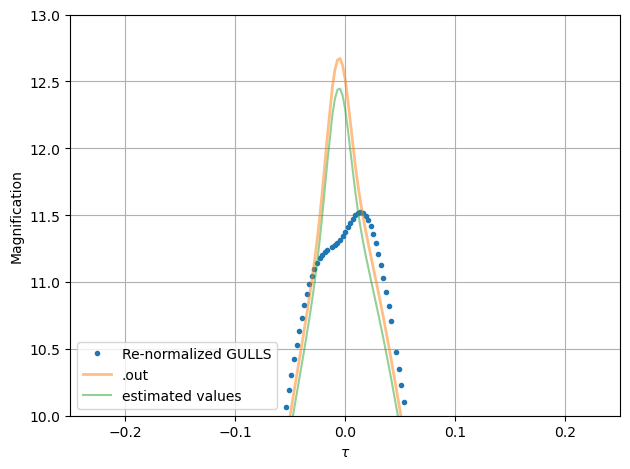

In [297]:
fs = 0.41432
magnification = (flux - (1 - fs)) / fs

plt.plot(tau_lc, magnification, label='Re-normalized GULLS', linestyle = 'none', marker ='.')
plt.plot(model_tau, model_mag, label=".out", lw=2, alpha=0.5)
plt.plot(model2_tau, model2_mag, label ="estimated values", alpha =.5)
plt.xlabel(r"$\tau$")
plt.ylabel("Magnification")
plt.xlim(-.25, .25)
plt.ylim(10, 13)

plt.legend(loc = 'lower left')
plt.grid(True)
plt.tight_layout()
plt.show()


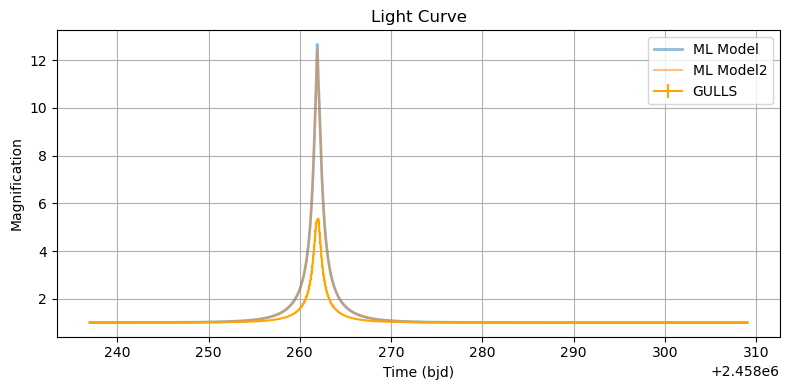

In [298]:
plt.figure(figsize=(8, 4))
plt.errorbar(bjd, flux, label='GULLS', color='orange', yerr=flux_error)
plt.plot(bjd, model_mag, label= "ML Model", lw=2, alpha = .5)
plt.plot(bjd, model2_mag, label ="ML Model2", alpha =.5)
plt.xlabel("Time (bjd)")
plt.ylabel("Magnification")
plt.title("Light Curve")

plt.xlim
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

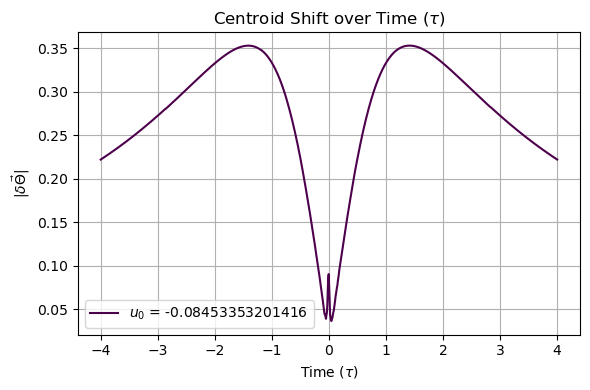

In [299]:
model.plot_centroid_shift()

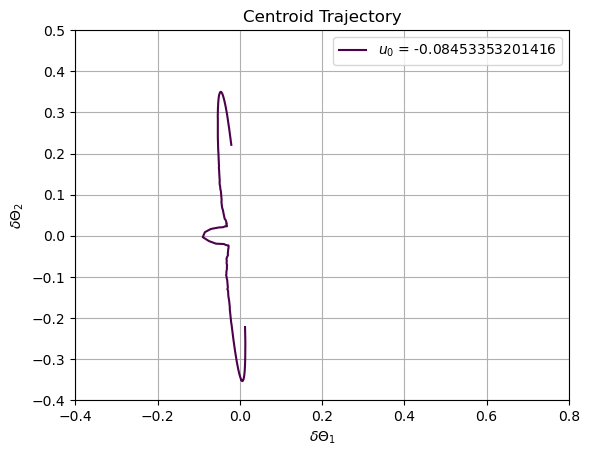

In [300]:
model.plot_centroid_trajectory()